In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 6:2:2
df = pd.read_csv('../../../Data/BTC-USD.csv')
df['Close'] = df['Close']
print(df)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df['Close'].iloc[:train_size]
test_data = df['Close'].iloc[train_size:train_size+test_size]
val_data = df['Close'].iloc[train_size+test_size:]

           Date          Open          High           Low         Close  \
0     9/17/2014    465.864014    468.174011    452.421997    457.334015   
1     9/18/2014    456.859985    456.859985    413.104004    424.440002   
2     9/19/2014    424.102997    427.834991    384.532013    394.795990   
3     9/20/2014    394.673004    423.295990    389.882996    408.903992   
4     9/21/2014    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
3188  6/10/2023  26481.761720  26531.044920  25501.835940  25851.240230   
3189  6/11/2023  25854.031250  26203.439450  25668.986330  25940.167970   
3190  6/12/2023  25934.285160  26087.919920  25675.197270  25902.500000   
3191  6/13/2023  25902.941410  26376.351560  25728.365230  25918.728520   
3192  6/14/2023  25920.257810  26041.800780  24902.152340  25124.675780   

         Adj Close        Volume  
0       457.334015  2.105680e+07  
1       424.440002  3.448320e

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26991.481, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26996.610, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26995.169, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26994.965, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26994.908, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26989.395, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26995.238, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26987.721, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26989.388, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26995.546, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26985.966, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26993.237, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26993.441, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26987.625, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[7115.947119   7122.19701603 7117.72096292 7120.92662396 7118.63079269
 7120.27502181 7119.09745731 7119.9408058  7119.33681623 7119.76938166
 7119.45958682 7119.68145578 7119.52255761 7119.63635735 7119.55485622
 7119.61322572 7119.57142263 7119.60136118 7119.57991978 7119.59527569
 7119.58427809 7119.59215435 7119.58651353 7119.59055338 7119.58766012
 7119.58973221 7119.58824822 7119.58931103 7119.58854987 7119.58909499]


In [6]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))
# EVS
evs = explained_variance_score(test_data, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
#MAPE
mape = mean_absolute_percentage_error(test_data, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The root mean squared error (RMSE) on test set: 24827.845
The explained variance score (EVS) on test set: 0.000
The mean absolute percentage error (MAPE) on test set: 0.512


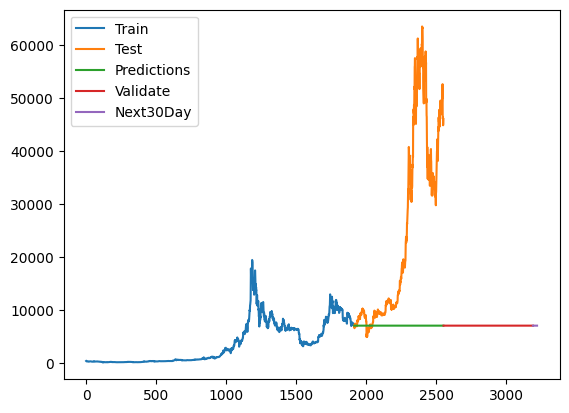

In [7]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [8]:
# test_data.index